In [1]:
import glob
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.applications import VGG19
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, PReLU, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from numpy.random import choice,randint
import shutil
MODELS_PATH = '/content/drive/MyDrive/DeepProjectDenoiser/noFineTuning/models'
OLD_MODEL_PATH = os.path.join(MODELS_PATH, 'old')
zip_dir = '/content/drive/MyDrive/DeepProject/immagini1.zip'
root_dir = '/content/drive/MyDrive/DeepProjectDenoiser/noFineTuning'
data_dir = '/content/immagini/DIV2K_'
loss_checkpoint = os.path.join(root_dir, 'checkpoints')


In [2]:
#import the drive folder and fetch the images
if not os.path.exists('immagini/'):
  drive.mount('/content/drive/',force_remount=True)
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall('immagini')

Mounted at /content/drive/


In [3]:
# use gdrive to definetily delete models file and all elements in the tresholds
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

In [4]:
def makeModel(input_shape):
  inp = Input(shape=input_shape)

  vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=input_shape)
  vgg.trainable = False

  vgg2 = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape=input_shape)
  vgg2.trainable = False

  x = vgg(inp)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = UpSampling2D((2, 2))(x)

  vgg2_extractor = tf.keras.Sequential(vgg2.layers[:4], name='vgg19_2')
  vgg2_model = vgg2_extractor(inp)

  x2 = Conv2D(128, (1, 1), activation='relu', padding='same')(vgg2_model)
  x2 = Conv2D(256, (1, 1), activation='relu', padding='same')(x2)
  x2 = UpSampling2D((2, 2))(x2)
  x2 = UpSampling2D((2, 2))(x2)

  xintermediate = Add()([x, x2])

  xout = Conv2D(256, (3, 3), activation='relu', padding='same')(xintermediate)
  xout = Conv2D(256, (3, 3), activation='relu', padding='same')(xout)
  xout = Conv2D(256, (3, 3), activation='relu', padding='same')(xout)
  xout = UpSampling2D((2, 2))(xout)

  xout = Conv2D(256, (3, 3), activation='relu', padding='same',dilation_rate=2)(xout)
  xout = Conv2D(256, (3, 3), activation='relu', padding='same',dilation_rate=2)(xout)
  xout = Conv2D(256, (3, 3), activation='relu', padding='same',dilation_rate=2)(xout)

  xout = Conv2D(64, (3, 3), activation='relu', padding='same')(xout)

  xout = Conv2D(3, (3, 3), activation='relu', padding='same')(xout)

  return tf.keras.Model(inp,xout)

In [5]:
common_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

def psnr_metric(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.)

def ssim_metric(y_true, y_pred):
  return tf.image.ssim(y_true, y_pred, max_val=1.)

Model = makeModel(input_shape = (None,None,3))
Model.compile(optimizer=common_optimizer, loss='mae', metrics=[[psnr_metric, ssim_metric]], loss_weights=1e3)
print(Model.summary())


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 vgg19 (Functional)             (None, None, None,   20024384    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   2359808     ['vgg19[0][0]']                  
                             

In [6]:
class Loader:
  def __init__(self, batch_size: int = 8, set_type="train"):
    self.selectedType = set_type
    self.batch_size = batch_size
    self.nimages = len(os.listdir('/content/immagini/DIV2K_' + self.selectedType + f"/{'LR' if self.selectedType == 'test' else 'HR'}"))
    self.nbatches = (self.nimages // batch_size) + (1 if (self.nimages % batch_size) > 0 else 0)
    self.batch_counter = 0
    self.all_images = glob.glob(f"{data_dir}{self.selectedType}/{'HR/*.png' if self.selectedType == 'train' else 'LR/*.jpg'}", recursive=True)
    random.shuffle(self.all_images)
    self.index = 0
    self.len = len(self.all_images)
    pass

  def noisy(self,noise_typ,image):
    if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = choice([0.0245,0.01,0.0135], p = [0.18,0.51,0.31])
      sigma = var**0.8
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
    elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
    else:
      return image

  def resizing_cropping(self,img,noise_typ):
    img1 = cv2.imread(img)
    h = img1.shape[0]
    w = img1.shape[1]
    random_h = random.randint(0,h-256)
    random_w = random.randint(0,w-256)
    img1 = img1[random_h:random_h+256, random_w:random_w+256]
    img1_high_resolution = np.array(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))/255.
    if np.random.random() < 0.5:
      img1_high_resolution = cv2.flip(img1_high_resolution, choice([0,1], 1)[0])
    if choice([0,1], 1)[0] == 1:
      img1_high_resolution = cv2.rotate(img1_high_resolution, choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE], 1)[0])

    img1_noised = self.noisy(noise_typ,img1_high_resolution)
    img1_low_resolution = cv2.resize(img1_noised, (64,64), interpolation=cv2.INTER_CUBIC)

    return img1_high_resolution,img1_low_resolution

  def __iter__(self):
    return self

  def __len__(self): # utile per usare loader in tqdm
    return self.nbatches

  def sample_images(self):
    images_batch = []
    for i in range(self.batch_size):
      position = (self.batch_counter * self.batch_size +i) % self.len
      if position >= self.len:
        break
      images_batch.append(self.all_images[position])
    HR = []
    LR = []
    noise_typ = ["gauss","poisson","without"]
    for img in images_batch:
      typ = choice(noise_typ, p = [0.41,0.41,0.18])
      img1_high_resolution,img1_low_resolution = self.resizing_cropping(img,typ)
      HR.append(img1_high_resolution)
      LR.append(img1_low_resolution)
    HR = np.array(HR)
    LR = np.array(LR)
    return HR, LR

  def sample_images_eval(self):
    # Make a list of all images inside the data directory of the LR images
    all_images_HR = glob.glob(f'{data_dir}{self.selectedType}/HR/*.png', recursive=True)
    all_images_LR = []
    all_images_LR = glob.glob(f'{data_dir}{self.selectedType}/LR/*x4.png', recursive=True)
    all_images_HR.sort()
    all_images_LR.sort()
    return all_images_HR,all_images_LR

  def __next__(self):
    batch_HR = []
    batch_LR = []
    if self.batch_counter == self.nbatches:
      self.reset()
      random.shuffle(self.all_images)
      raise StopIteration
    batch_HR,batch_LR = self.sample_images()
    self.batch_counter+=1
    return batch_HR,batch_LR

  def reset(self):
    self.batch_counter = 0

  def save_images(self, original_im, sr_im,original_HR_im,selectedType, epoch : int = 0,):
    path = os.path.join('/content/drive/MyDrive/DeepProjectDenoiser/noFineTuning/results/', selectedType)
    if not os.path.exists(path):
      os.makedirs(path)

    plt.imshow(original_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'or')))
    plt.show()

    plt.imshow(sr_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'sr')))
    plt.show()

    plt.imshow(original_HR_im)
    if epoch % 9 == 0 or selectedType == 'valid':
      plt.savefig(os.path.join(path,'X_{}_{}.png'.format(epoch,'or_HR')))
    plt.show()


In [7]:
def save_weights(Model,epoch):
  files_list = glob.glob(f'{MODELS_PATH}/*.hdf5')
  for files in files_list:
      shutil.move(files, OLD_MODEL_PATH )

  modelname = os.path.join(MODELS_PATH, f'Model_{epoch}.hdf5')
  Model.save(modelname,include_optimizer=True)

  filelist = glob.glob(f'{OLD_MODEL_PATH}/*')
  for f in filelist:
    os.remove(f)
  clean_trash()

def load_weights():
  weights = glob.glob(f'{MODELS_PATH}/*.hdf5', recursive=True)
  #load wheigh set epoch
  initial_epoch = 0
  if weights:
    initial_epoch = int(weights[0].split('_')[-1].split('.')[0])+1
    Model.load_weights(weights[0])
    print('loaded Model, ',weights[0])
  return initial_epoch

def save_checkpoint(loss,psnr,ssim,selectedType):
  line = f'{loss};{psnr};{ssim}\n'
  # save losses
  with open(os.path.join(loss_checkpoint,f'losses_{selectedType}.chk'), mode="a") as loss_file:
    loss_file.write(line)

def save_checkpoint_eval(psnr,ssim):
  for i,el in enumerate(range(len(psnr))):
    line = f'{psnr[i]};{ssim[i]}\n'
    # save losses
    with open(os.path.join(loss_checkpoint,f'losses_eval.chk'), mode="a") as loss_file:
      loss_file.write(line)


def load_checkpoint(selectedType):
    losses = []
    psnr = []
    ssim = []
    with open(os.path.join(loss_checkpoint,f"losses_{'eval' if selectedType == 'valid' else selectedType}.chk"), "r") as loss_files:
      if selectedType == 'valid':
        while line := loss_files.readline():
          ps,ss = line.split(";")
          psnr.append(float(ps))
          ssim.append(float(ss))
        return np.array(psnr), np.array(ssim)
      else:
        while line := loss_files.readline():
          loss,ps,ss = line.split(";")
          losses.append(float(loss))
          psnr.append(float(ps))
          ssim.append(float(ss))
        return np.array(losses), np.array(psnr), np.array(ssim), len(losses)

def clean_trash():
  # clear trash
  for a_file in my_drive.ListFile({'q': "trashed = true"}).GetList():
    print(f'the file "{a_file["title"]}", is about to get deleted permanently.')
    try:
      a_file.Delete()
    except Exception as e:
      print(e)

In [ ]:
def train_computeLoss(batch_size, nbatches, epoch, initial_epoch,image_loader):
  losses = []
  psnr = []
  ssim = []
  Model.trainable = True
  Model.get_layer('vgg19').trainable = False
  Model.get_layer('vgg19_2').trainable = False

  for hr_imgs,lr_imgs in tqdm(image_loader, desc=f"[*] Epoch=> {epoch}"):
    gen_imgs = None
    if hr_imgs is None:
      return False # failure

    loss, ps,ss = Model.train_on_batch(lr_imgs,hr_imgs)
    losses.append(loss)
    psnr.append(ps)
    ssim.append(ss)

  losses = np.array(losses)
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  losses = np.sum(losses) / len(losses)
  ssim =  np.sum(ssim) / len(ssim)
  psnr =  np.sum(psnr) / len(psnr)

  gen_imgs = Model.predict_on_batch(lr_imgs)

  print(f'epoch= {epoch} loss = {losses} --> ssim = {ssim} -->psnr = {psnr}\n')

  return lr_imgs[0],gen_imgs[0], hr_imgs[0], losses, ssim, psnr


In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()
def test_computeLoss(batch_size, nbatches, initial_epoch,image_loader):

  losses = []
  psnr = []
  ssim = []
  Model.trainable = False
  for hr_imgs,lr_imgs in tqdm(image_loader, desc=f"[*] Epoch=> {initial_epoch}"):

    if hr_imgs is None:
      return False

    gen_imgs = Model.predict_on_batch(lr_imgs)
    loss = 1e3 * mae(hr_imgs,gen_imgs)

    batches_psnr = tf.image.psnr(tf.cast(hr_imgs, tf.float32),tf.cast(gen_imgs, tf.float32), max_val=1)
    batches_ssim = tf.image.ssim(tf.cast(hr_imgs, tf.float32),tf.cast(gen_imgs, tf.float32), max_val=1)

    losses.append(loss)
    psnr.append(tf.reduce_mean(batches_psnr))
    ssim.append(tf.reduce_mean(batches_ssim))

  losses = np.array(losses)
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  losses = np.sum(losses) / len(losses)
  ssim =  np.sum(ssim) / len(ssim)
  psnr =  np.sum(psnr) / len(psnr)

  Model.trainable = True
  Model.get_layer('vgg19').trainable = False
  Model.get_layer('vgg19_2').trainable = False
  print(f'epoch= {initial_epoch} loss = {losses} --> ssim = {ssim} -->psnr = {psnr}\n')

  return lr_imgs[0],gen_imgs[0], hr_imgs[0],losses, ssim, psnr


In [ ]:
def test(batch_size,selectedType):
  initial_epoch = load_weights()

  initial_epoch = initial_epoch -1
  image_loader = Loader(batch_size=batch_size, set_type=selectedType)
  batch_size =  image_loader.batch_size
  nbatches = image_loader.nbatches
  lr_img,gen_img, or_hr_im,loss, ssim, psnr = test_computeLoss(batch_size, nbatches, initial_epoch, image_loader)

  image_loader.save_images(lr_img ,gen_img,or_hr_im,selectedType,initial_epoch)
  save_checkpoint(loss, ssim, psnr,selectedType)
  image_loader.reset()

In [ ]:
def train(epochs,batch_size,selectedType):
  initial_epoch = load_weights()
  image_loader = Loader(batch_size=batch_size, set_type=selectedType)
  batch_size =  image_loader.batch_size
  nbatches = image_loader.nbatches


  if initial_epoch != 0:
    _, _, _,epoch_train = load_checkpoint(selectedType = 'train' )
    _, _, _,epoch_test = load_checkpoint(selectedType = 'test' )
    if epoch_test < epoch_train:
      test(batch_size=8,selectedType='test')

  for epoch in range(initial_epoch, 150):
    lr_img,gen_img, or_hr_im,loss, ssim, psnr= train_computeLoss(batch_size, nbatches, epoch, initial_epoch, image_loader)

    image_loader.save_images(lr_img ,gen_img,or_hr_im,selectedType,epoch)
    save_weights(Model,epoch)
    save_checkpoint(loss, ssim, psnr,selectedType)
    image_loader.reset()
    test(batch_size=8,selectedType='test')

In [8]:
def eval_computeLoss(selectedType):
  image_loader = Loader(batch_size=8, set_type=selectedType)
  psnr = []
  ssim = []
  load_weights()
  Model.trainable = False

  hr_imgs,lr_imgs = image_loader.sample_images_eval()

  if hr_imgs is None:
      return False

  for index,hr_img in enumerate(hr_imgs):
    print(index)
    hr_img = cv2.imread(hr_img)
    h = hr_img.shape[0]
    w = hr_img.shape[1]
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    hr_img = hr_img[(h//2)-128:(h//2)+128, (w//2)-128:(w//2)+128]
    hr_img = np.array(hr_img) /255.

    noise_typ = ["gauss","poisson","without"]
    typ = choice(noise_typ, p = [0.41,0.41,0.18])
    lr_img = cv2.resize(hr_img, (64,64), interpolation=cv2.INTER_CUBIC)
    lr_img = image_loader.noisy(noise_typ,lr_img)

    hr_img = tf.expand_dims(hr_img, axis=0)
    lr_img = tf.expand_dims(lr_img, axis=0)


    gen_img = Model.predict_on_batch(lr_img)

    batches_psnr = tf.image.psnr(tf.cast(hr_img, tf.float32),tf.cast(gen_img, tf.float32), max_val=1)
    batches_ssim = tf.image.ssim(tf.cast(hr_img, tf.float32),tf.cast(gen_img, tf.float32), max_val=1)
    psnr.append(tf.reduce_mean(batches_psnr))
    ssim.append(tf.reduce_mean(batches_ssim))

    #if np.isinf(np.array(tf.reduce_mean(batches_psnr))):
    if np.random.random() < 0.3:
      gen_img = np.squeeze(gen_img, axis=0)
      lr_img = np.squeeze(lr_img, axis=0)
      hr_img = np.squeeze(hr_img, axis=0)
      image_loader.save_images(lr_img ,gen_img,hr_img,selectedType,index)
      cv2.imwrite('/content/image.png', cv2.cvtColor(gen_img *255., cv2.COLOR_RGB2BGR))
      cv2.imwrite('/content/noisedimage.png', cv2.cvtColor((lr_img *255.).astype(np.uint8), cv2.COLOR_RGB2BGR))
  psnr = np.array(psnr)
  ssim = np.array(ssim)

  #ssim =  np.sum(ssim) / len(ssim)
  #psnr =  np.sum(psnr) / len(psnr)
  save_checkpoint_eval(psnr,ssim)


  print(f' ssim = {ssim} -->psnr = {psnr}\n')

  Model.trainable = True
  Model.get_layer('vgg19').trainable = False
  Model.get_layer('vgg19_2').trainable = False

In [ ]:
eval_computeLoss(selectedType = 'valid')

In [ ]:
loss_train, psnr_train, ssim_train,epoch_train= load_checkpoint(selectedType = 'train' )
loss_test, psnr_test, ssim_test,epoch_test= load_checkpoint(selectedType = 'test' )
psnr_valid, ssim_valid = load_checkpoint(selectedType = 'valid' )

epochs = range(1, epoch_train + 1)
path = '/content/drive/MyDrive/DeepProjectDenoiser/noFineTuning/results/plots'

plt.plot(epochs, loss_train, '-r', label='MeanAbsoluteError_Train')
plt.plot(epochs, loss_test, '-b', label='MeanAbsoluteError_Test')
plt.xlabel('Epochs')
plt.ylabel('Losses Value truncated')
plt.title('Train_Loss')
plt.legend(loc="upper left")
plt.ylim([0,300])

#plt.xlim([0,190])

plt.savefig(os.path.join(path,'loss_test_train'))
plt.show()

plt.plot(epochs, loss_train, '-r', label='MeanAbsoluteError_Train')
plt.plot(epochs, loss_test, '-b', label='MeanAbsoluteError_Test')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('Train_Loss')
plt.legend(loc="upper left")
#plt.ylim([0,2500])

#plt.xlim([0,190])

plt.savefig(os.path.join(path,'loss_test_train_chopped'))
plt.show()

plt.plot(epochs, psnr_test, '-b', label='PSNR_test')
plt.plot(epochs, psnr_train, '-r', label='PSNR_train')
plt.xlabel('Epochs')
plt.ylabel('Losses Value')
plt.title('PSNR')
#plt.xlim([0,190])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'psnr_train_test'))
plt.show()

plt.plot(epochs, ssim_test, '-b', label='SSIMtest')
plt.plot(epochs, ssim_train, '-r', label='SSIMtrain')
plt.xlabel('Epochs')
plt.ylabel('Losses Values')
plt.title('SSIM')
#plt.xlim([0,190])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'ssim_train_test'))

plt.show()

epochs = range(1, 100 + 1)

plt.plot(epochs, ssim_valid, '-b', label='SSIMvalid')
plt.plot(epochs, psnr_valid, '-r', label='PSNRvalid')
plt.xlabel('Samples')
plt.ylabel('Metrics')
plt.title('SSIM PSNR VALIDATION')
plt.xlim([0,100])
plt.legend(loc="lower left")
plt.savefig(os.path.join(path,'PSNRSSIMVALID'))

plt.show()

In [ ]:
train(epochs=50, batch_size=8,selectedType='train')

loaded Model,  /content/drive/MyDrive/DeepProjectDenoiser/noFineTuning/models/Model_116.hdf5
1/1 [==============================] - 14s 14s/step


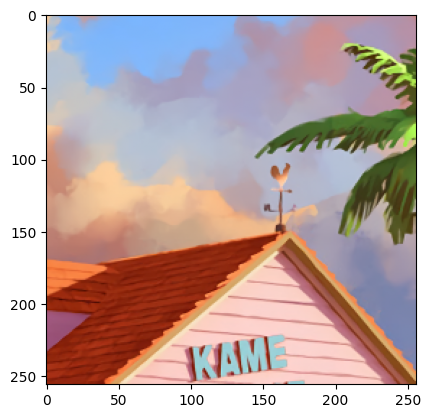

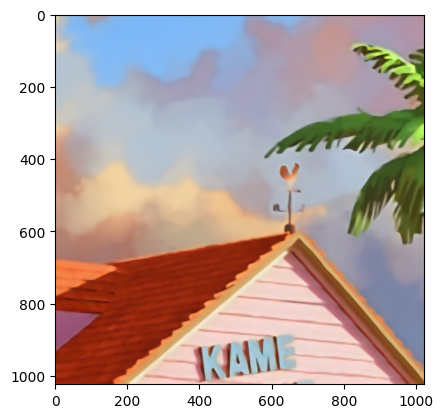

--------------
1/1 [==============================] - 1s 935ms/step


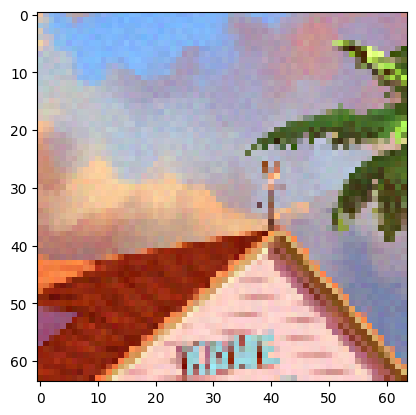

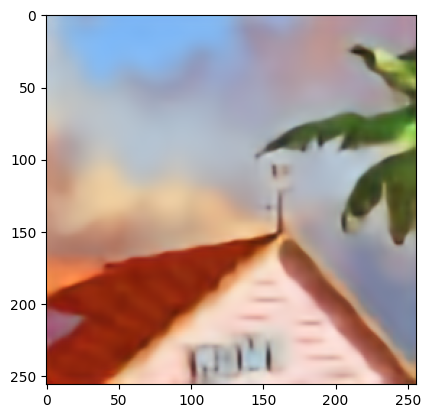

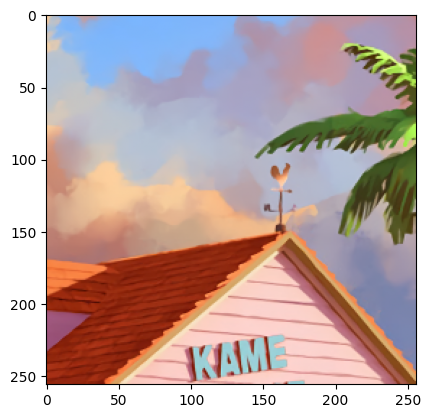

--------------
1/1 [==============================] - 0s 36ms/step


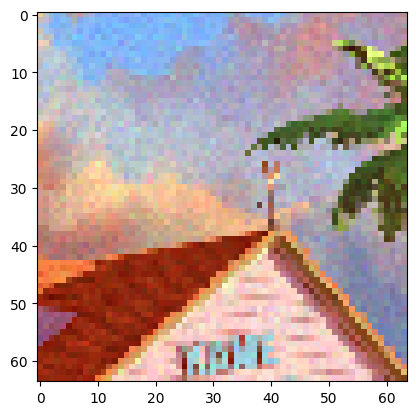

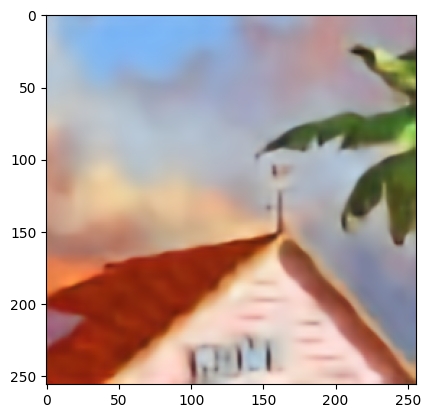

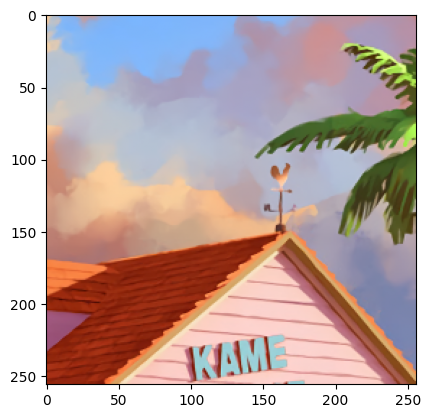

 256 --------------
1/1 [==============================] - 0s 24ms/step


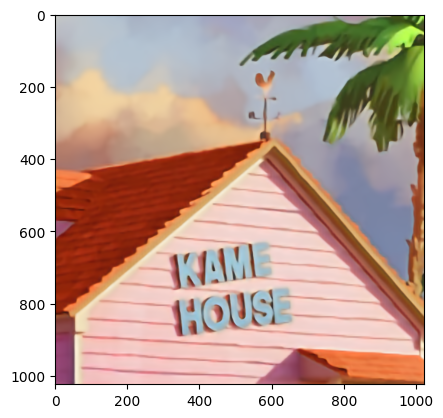

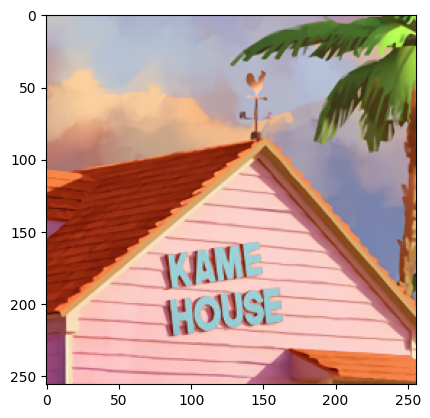

In [ ]:
initial_epoch = load_weights()
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = choice([0.025,0.01,0.013], p = [0.18,0.51,0.31])
    sigma = var**0.8
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  else:
    return image

img1 = cv2.imread('/content/1024.png')
h = img1.shape[0]
w = img1.shape[1]
random_h = random.randint(0,h-256)
random_w = random.randint(0,w-256)
img1 = img1[384:640, 650:906]
img1 = np.array(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))/255.

imim = Model.predict(np.expand_dims(img1,axis=0))
plt.imshow(img1)
plt.show()
plt.imshow(tf.squeeze(imim))
plt.show()
print("--------------")
imin = cv2.resize(noisy('gauss',img1), (64,64), interpolation=cv2.INTER_CUBIC)
imout = Model.predict(np.expand_dims(imin,axis=0))
plt.imshow(imin)
plt.show()
plt.imshow(tf.squeeze(imout))
plt.show()
plt.imshow(img1)
plt.show()
print("--------------")

imin = cv2.resize(noisy('poisson',img1), (64,64), interpolation=cv2.INTER_CUBIC)
imout = Model.predict(np.expand_dims(imin,axis=0))
plt.imshow(imin)
plt.show()
plt.imshow(tf.squeeze(imout))
plt.show()
plt.imshow(img1)
plt.show()
print(" 256 --------------")

img1 = cv2.imread('/content/1024.png')
h = img1.shape[0]
w = img1.shape[1]
random_h = random.randint(0,h-256)
random_w = random.randint(0,w-256)
img1 = img1[random_h:random_h+256, random_w:random_w+256]
img1 = np.array(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))/255.


imout = Model.predict(np.expand_dims(img1,axis=0))
plt.imshow(tf.squeeze(imout))
plt.show()
plt.imshow(img1)
plt.show()
